# Model for Credit Default prediction

Author: sharon

In [1]:
# Data Handling
import pandas as pd
import numpy as np
import time

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# System
import os
from os import path
import sys
import warnings
import json
warnings.filterwarnings('ignore')

# Modelling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.impute import SimpleImputer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, log_loss
import shap
import optuna 

For the model the steps are as follow

1. Preprocessing:
    1. One Hot Encoding for categorical variables
    2. Standardizes the data for PCA


2. SMOTE oversampling to handle class imbalance:
    - SMOTE generates synthetic samples for the minority class to balance the dataset

3. Model Trainig :
    1. Here an XGBoost model will be used directly, but more algorithm can be tested.
    2. Hyperparameters tuning using GridSearchCV
    3. Evaluation metrics

4. Model Interpretation using SHAP values

In [2]:
# Define Variables for files and paths

MAIN_DIR = path.dirname(__vsc_ipynb_file__)
OUTPUT_DIR = path.join(MAIN_DIR,"output")
INPUT_DIR = path.join(MAIN_DIR, "data")

DF_PATH = path.join(OUTPUT_DIR, "df_train_test.csv")

In [3]:
# import functions from utils.py

sys.path.append(MAIN_DIR)
from utils import *

# Preprocess Data

- **Missing data**: In this step the NA values are actually processed
    - Drop columns with more than 65% of NA values. At first they were not drop because in the EDA it is usefult to understand NA patterns.
    - XGBoost handle natively missing data, but some simple imputations could be done

- **Encoding**: One hot Encoding

    - When there is categorical data, it has to be consideren how to handle it, if applying One-hot encoding or label encoding, depending on the nature of the variable. Also, its important to consider the dimensionality of the dataset, when feature space grows (this can happen with OHE) and lead to the curse of dimensionality.

- **Resampling**: XGBoost handles class imbalance natively by setting the parameter scale_pos_weight. But if necessary resampling techiques might by used 
    -Avoids creating synthetic samples, which can sometimes introduce noise.



In [4]:
# Read data with some new features and tranformations done in EDA.ipynb
df = pd.read_csv(DF_PATH).drop('uuid', axis = 1)
X = df.drop(columns = ['default']).copy()
y = df['default']

categorical_columns = X.select_dtypes(include=['object', 'category']).columns

X[categorical_columns] = X[categorical_columns].astype('category')

# Split data
X_train_comp, X_test_comp, y_train, y_test = train_test_split(X, y, test_size=0.215, random_state=42, stratify=y)

# compute NA counts on training set to avoid data leakage
print('\nNA counts in training set')
na_counts = count_na(X_train_comp, verbose=True)# Get na proportions per columns
na_drop = na_counts.index[na_counts>65].to_list() # Drop columns that have more than 80% of 

print('\ncolumns to drop')
print('\n'.join(na_drop))

# Drop columns with more than 65% NA
X_train = X_train_comp.drop(columns=na_drop)
X_test = X_test_comp.drop(columns=na_drop)

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)


print("\nAfter preprocessing")
print('Train set shape: ', X_train.shape)
print('Test set shape: ', X_test.shape)



NA counts in training set
Number of columns with missing values: 256

columns to drop
person_bith_year_month_1_no_aggregation
client_type_1_month_9_no_aggregation
plan_data_month_12_no_aggregation
billing_pattern_03_last_12_months_mean
line_balance_type_01_month_1_sum
billing_pattern_08_last_12_months_mean
line_balance_type_07_month_1_sum
line_balance_type_04_last_6_months_max

After preprocessing
Train set shape:  (14604, 251)
Test set shape:  (4001, 251)


# Fit XGBoost wit all features

First we are going to fit the xgboost model with all the variables and use SHAP values to select the most relevant features.

In [5]:
params = {
    "eta": 0.01,
    "scale_pos_weight":len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgb.train(
    params,
    dtrain,
    5000,
    evals=[(dtest, "test")],
    verbose_eval=100,
    early_stopping_rounds=20
)

[0]	test-logloss:0.45614
[40]	test-logloss:0.44886


Select features to keep using shap values feature importances, and keeping the variables that accumulate 95% of the total importance.

In [6]:
# Initialize Shap values
explainer = shap.TreeExplainer(model)
explanation = explainer(dtest)

In [7]:

# Get feature Importances
importances = []
for i in range(explanation.values.shape[1]):
    importances.append(np.mean(np.abs(explanation.values[:, i])))
    
feature_importances = {fea: imp for imp, fea in zip(importances, dtrain.feature_names)}

# Keep features that accumluate 95% of the total importance
cumsum = np.cumsum(sorted(importances, reverse=True))
threshold_idx = np.searchsorted(cumsum, 0.95 * cumsum[-1])
threshold = sorted(importances, reverse=True)[threshold_idx]

selected_features = [fea for fea, imp in feature_importances.items() if imp>threshold]

len(selected_features)


165

# Model: XGBoost with HP tuning

In [8]:
metric = 'logloss'
base_params = {
    'objective': 'binary:logistic',
    'eval_metric': metric,
    'scale_pos_weight':len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    'seed':42
}



In [9]:
dtrain_sel = xgb.DMatrix(X_train[selected_features], label=y_train, enable_categorical=True)
dtest_sel = xgb.DMatrix(X_test[selected_features], label=y_test, enable_categorical=True)

## First tune tree parameters

In [10]:
learning_rate = 0.3

params = {
    'tree_method': 'approx',
    'learning_rate': learning_rate
}
params.update(base_params)


In [11]:
def objective(trial):
    params = {
        'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log=True),
        'learning_rate': learning_rate,
    }
    num_boost_round = 10000
    params.update(base_params)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'test-{metric}')
    model = xgb.train(params=params, dtrain=dtrain_sel, num_boost_round=num_boost_round,
                      evals=[(dtest_sel, 'test')],
                      early_stopping_rounds=50,
                      verbose_eval=0,
                      callbacks=[pruning_callback])
    trial.set_user_attr('best_iteration', model.best_iteration)
    return model.best_score

Create new study, stop after 300 seconds runing

In [12]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
tic = time.time()
while time.time() - tic < 300:
    study.optimize(objective, n_trials=1)

[I 2025-01-19 23:33:59,128] A new study created in memory with name: no-name-2a3f4dce-1e0b-464b-9f1e-5cd502e5dcf0
[I 2025-01-19 23:34:18,237] Trial 0 finished with value: 0.5926397568309971 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'min_child_weight': 150, 'subsample': 0.24041677639819287, 'colsample_bynode': 0.2403950683025824, 'reg_lambda': 0.001800728515054226}. Best is trial 0 with value: 0.5926397568309971.
[I 2025-01-19 23:35:16,005] Trial 1 finished with value: 0.48758797516526786 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9729188669457949, 'colsample_bynode': 0.8491983767203796, 'reg_lambda': 0.008587261143813469}. Best is trial 1 with value: 0.48758797516526786.
[I 2025-01-19 23:35:51,742] Trial 2 finished with value: 0.5717367497754628 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 132, 'subsample': 0.48875051677790415, 'colsample_bynode': 0.36210622617823773, 'reg_lambda': 0.490

In [13]:
print('Stage 1 ==============================')
print(f'best score = {study.best_trial.value}')
print('boosting params ---------------------------')
print(f'fixed learning rate: {learning_rate}')
print(f'best boosting round: {study.best_trial.user_attrs["best_iteration"]}')
print('best tree params --------------------------')
for k, v in study.best_trial.params.items():
    print(k, ':', v)

Stage 1 ==============================
best score = 0.48758797516526786
boosting params ---------------------------
fixed learning rate: 0.3
best boosting round: 35
best tree params --------------------------
tree_method : approx
max_depth : 10
min_child_weight : 6
subsample : 0.9729188669457949
colsample_bynode : 0.8491983767203796
reg_lambda : 0.008587261143813469


## Tune boosting parameters
Lower learning rate

In [14]:
low_learning_rate = 0.01

params = {}
params.update(base_params)
params.update(study.best_trial.params)
params['learning_rate'] = low_learning_rate
model_stage2 = xgb.train(params=params, dtrain=dtrain_sel, 
                         num_boost_round=10000,
                         evals=[(dtest_sel, 'test')],
                         early_stopping_rounds=50,
                         verbose_eval=0)

In [15]:
def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:

    y_true = dmat.get_label()
    y_pred_proba = model.predict(dmat)
    loss = log_loss(y_true, y_pred_proba)
    print(f"Log Loss: {loss:.4f}")
    return loss


In [16]:
print('Stage 2 ==============================')
print(f'best score = {score_model(model_stage2, dtest_sel)}')
print('boosting params ---------------------------')
print(f'fixed learning rate: {params["learning_rate"]}')
print(f'best boosting round: {model_stage2.best_iteration}')

Stage 2 ==============================
Log Loss: 0.4328
best score = 0.43284633832985
boosting params ---------------------------
fixed learning rate: 0.01
best boosting round: 1283


In [17]:

path = os.path.join(OUTPUT_DIR, 'final_params.json')
with open(path, 'w') as f:
    json.dump(params, f, indent=4)

## Final Model

In [18]:

model_final = xgb.train(params=params, dtrain=dtrain_sel, 
                        num_boost_round=model_stage2.best_iteration,
                        verbose_eval=0)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3317
           1       0.42      0.27      0.33       684

    accuracy                           0.81      4001
   macro avg       0.64      0.60      0.61      4001
weighted avg       0.78      0.81      0.79      4001

n\Logloss: 0.4326 


[Text(0, 0.5, ''), Text(0, 1.5, '')]

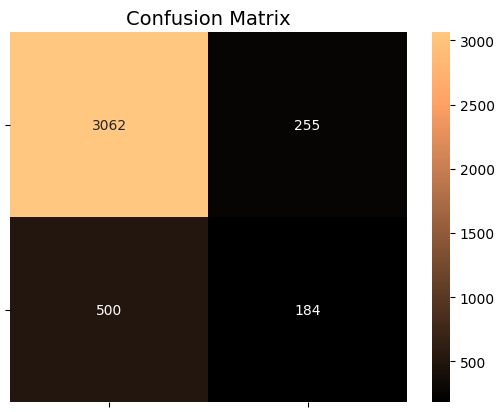

In [19]:
y_pred_proba = model_final.predict(dtest_sel)

y_pred = (y_pred_proba > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

print(f'n\Logloss: {log_loss(y_test,y_pred_proba):.4f} ')

# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)


g = sns.heatmap(conf_mat,  annot=True, cmap=plt.cm.copper, fmt='0.0f')
g.set_title("Confusion Matrix", fontsize=14)
g.set_xticklabels(['', ''], fontsize=14, rotation=90)
g.set_yticklabels(['', ''], fontsize=14, rotation=360)


# Feature Importance

In [52]:
# display df
feature_names = dtest_sel.feature_names
X_test_values = dtest_sel.get_data().toarray()


X_display = pd.DataFrame(X_test_values, columns=feature_names)

In [53]:
# Model interpretability with SHAP
explainer = shap.Explainer(model_final)
shap_values = explainer(X_display)

SHAP shows the contribution or the importance of each feature on the prediction of the model.
The plot below, display the variables with the most importance for the model according to Shap values.

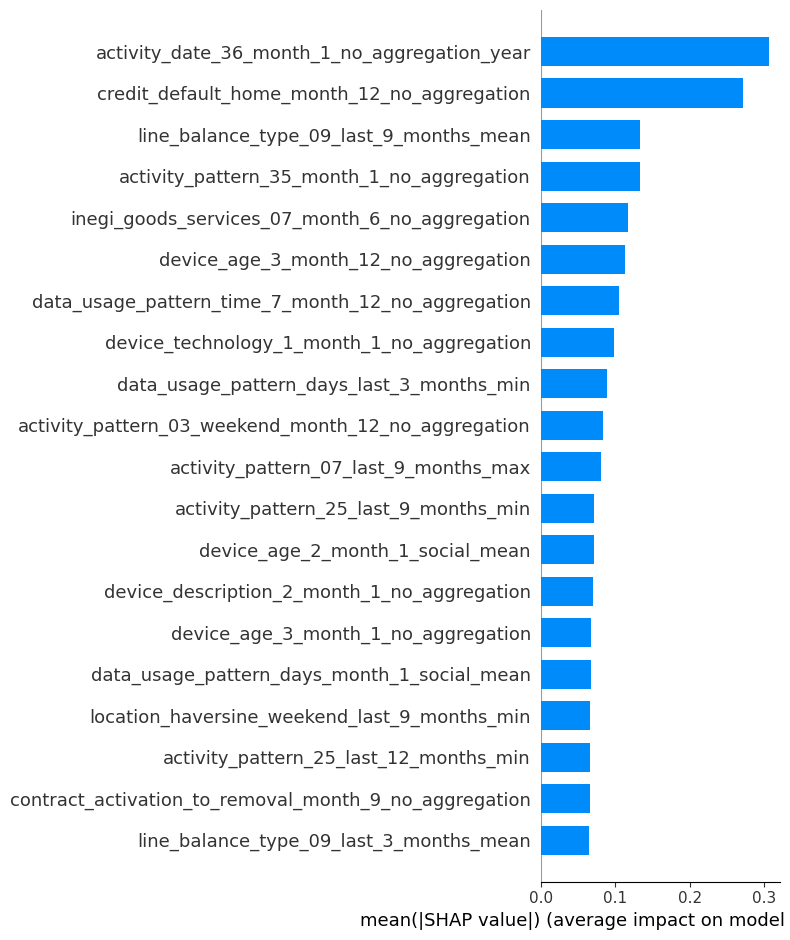

In [ ]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

The plot below shows that higher values of contract_activation_to_removal_month_9_no_agg have negative impact on the model output, while for the variable ctivity_date_36_aggregation_year is the opposite.

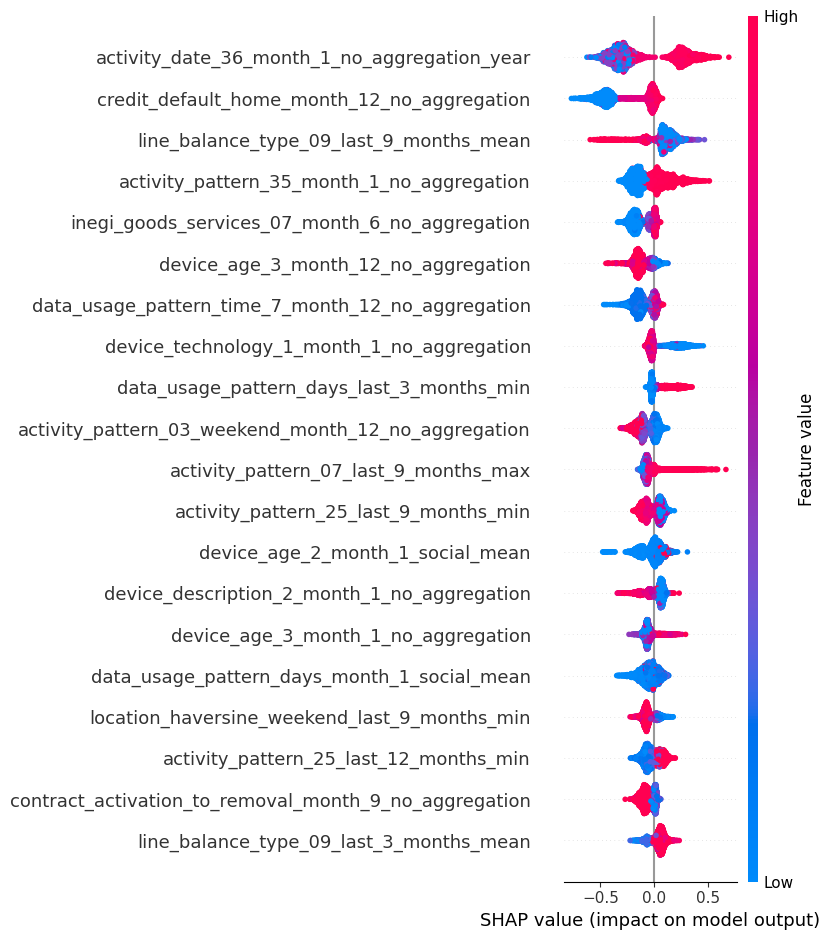

In [54]:
# Plot SHAP summary
shap.summary_plot(shap_values, X_display)

# Predictions


In [58]:
df_predictions = pd.read_csv(os.path.join(OUTPUT_DIR, 'df_prediction.csv'))

# Preprocess
df_predictions[categorical_columns] = df_predictions[categorical_columns].astype('category')
df_predictions = df_predictions.drop(columns = na_drop)

X_preds = df_predictions[selected_features]
d_preds = xgb.DMatrix(X_preds, enable_categorical=True)

# Generate predictions
predictions = model_final.predict(d_preds)

df_results = pd.DataFrame(
    {
        'uuid':df_predictions['uuid'],
        'default_pred':predictions
    }
)

df_results.to_csv(os.path.join(OUTPUT_DIR, 'model_predict_proba.csv'), index=False)